<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_Toluene_0520_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toluene

In [1]:
!pip install rdkit
!pip install molmass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.7 MB/s eta 0:00:00


In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula
import matplotlib.pyplot as plt
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors

#1. Necessary functions

In [3]:
# Function to create radical
def create_radical(smiles, aromatic=False):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    radical_parttern = "[c*]" if aromatic else "[C*]"
    radical = Chem.MolFromSmarts(radical_parttern)

    if mol.HasSubstructMatch(radical):
      Chem.rdmolops.SanitizeMol(mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
      return Chem.MolToSmiles(mol)
    else:
      return None

# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Ring opening function
def break_aromatic_rings(mol):

    # Define patterns
    o2_pattern = Chem.MolFromSmarts('c1ccc(OO)cc1')

    # Find matching substructures
    matches_o2 = mol.GetSubstructMatches(o2_pattern)

    # Break the ring
    rwmol = Chem.RWMol(mol)
    for match in matches_o2:
        ring_atoms = list(match)

        no_atom_idx = ring_atoms[3]

        # Find the bond
        for bond in rwmol.GetAtomWithIdx(no_atom_idx).GetBonds():
            connected_atom_idx = bond.GetOtherAtomIdx(no_atom_idx)
            if connected_atom_idx in ring_atoms:
                bond_to_break_idx = bond.GetIdx()
                break

        Chem.Kekulize(rwmol, clearAromaticFlags=True)

        rwmol.RemoveBond(no_atom_idx, connected_atom_idx)

        # Add hydrogens
        rwmol.GetAtomWithIdx(no_atom_idx).SetNumExplicitHs(rwmol.GetAtomWithIdx(no_atom_idx).GetNumImplicitHs() + 1)
        rwmol.GetAtomWithIdx(connected_atom_idx).SetNumExplicitHs(rwmol.GetAtomWithIdx(connected_atom_idx).GetNumImplicitHs() + 1)

        # Update aromaticity and sanitize
        Chem.Kekulize(rwmol, clearAromaticFlags=True)
        Chem.SanitizeMol(rwmol)

    return rwmol.GetMol()

# Trace reaction Function
def trace_reaction_path(target_product_smiles, reaction_history_1, reaction_history_2):
    """Traces the reaction pathway through reaction_histories"""

    reaction_path = []
    current_product = target_product_smiles
    combined_history = reaction_history_2 + reaction_history_1

    # Search in reaction_history_2
    for i in range(len(reaction_history_2) - 1, -1, -1):
        # Check if the tuple has enough elements before accessing index 2
        if len(reaction_history_2[i]) > 2 and reaction_history_2[i][2] == current_product:
            reaction_path.insert(0, reaction_history_2[i])
            current_product = reaction_history_2[i][0]
            break

    # Searching in reaction_history_1
    if reaction_path:
        for i in range(len(reaction_history_1) - 1, -1, -1):
            # Check if the tuple has enough elements before accessing index 2
            if len(reaction_history_1[i]) > 2 and reaction_history_1[i][2] == reaction_path[0][0]:
                reaction_path.insert(0, reaction_history_1[i])
                current_product = reaction_history_1[i][0]
                break

   # Create a combined history for integrated searching
    while current_product != 'Cc1ccccc1':  # Trace back to Toluene
        found_precursor = False

        for i in range(len(combined_history) - 1, -1, -1):
            step = combined_history[i]

            # Check for regular reactions or ring-opening steps
            if len(step)>2 and step[2] == current_product:
                reaction_path.insert(0, step)
                current_product = step[0]
                found_precursor = True
                break

        if not found_precursor:
            break

    return reaction_path

# 2. Experimental data with mass calculation

In [4]:
# Upload a experimental file
exp_data = pd.read_excel('SOA_results_NH3_CHON_kien.xlsx',sheet_name='Tol_NH3_CHON')

# Add new column to the dataframe:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)

exp_data.head()

Class  DBE  Neutral_DBE     Formula     Exp_m/z  neutral_mass    pos_mass  \
0    NO4  5.5            5     C7H7NO4  168.030370    169.038195  170.045995   
1    NO4  5.5            5     C6H5NO4  154.014731    155.022556  156.030356   
2   N2O6  6.5            6    C7H6N2O6  213.015519    214.023344  215.031144   
3  N2O10  3.5            3  C7H12N2O10  283.042127    284.049952  285.057752   
4  N3O13  3.5            3  C7H13N3O13  346.037477    347.045302  348.053102   

    Mono_Abund  Total_Abund    Calc_m/z  ...  #O  #S     H/C     N/C     O/C  \
0  84906561.99  91434808.22  168.030231  ...   4   0  1.0000  0.1429  0.5714   
1  61072644.65  64970660.40  154.014581  ...   4   0  0.8333  0.1667  0.6667   
2  15825731.09  17159318.81  213.015309  ...   6   0  0.8571  0.2857  0.8571   
3  13027120.30  14047110.36  283.041918  ...  10   0  1.7143  0.2857  1.4286   
4   9003501.35   9746036.59  346.037561  ...  13   0  1.8571  0.4286  1.8571   

   S/C     Osc  Neutral_Mass       [M-H]       [M+H]  
0    0 -0.4286    169.037508  168.029683  170.045333  
1    0 -0.1666    155.021858  154.014033  156.029683  
2    0  0.0000    214.022586  213.014761  215.030411  
3    0 -0.2857    284.049195  283.041370  285.057020  
4    0  0.0000    347.044837  346.037012  348.052662  

[5 rows x 23 columns]

#3. Reactions of Toluene with different species

In [5]:
reaction_rules_1 = [

    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][*]'),#
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][OH]'),#
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N+](=O)[O-]'),#
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N](=O)'),#
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][NH2]'),#
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1]OO'),#
    AllChem.ReactionFromSmarts('[c:1][CH3]>>[c:1]C=O'), # Toluene to benzaldehyde (Side-chain oxidation)
    AllChem.ReactionFromSmarts('[c:1][CH3]>>[c:1][CH2OH]'),   # Benzyl alcohol (Benzylic hydroxylation)
]

In [6]:
###--------Simulation part_1---------###
chemical_space_1 = {'Cc1ccccc1'}  # Toluene
num_iterations_1 = 5

# Comparison conditions
tolerance = 0.0000001  # 0.1ppm
matching_excel_info = []

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

# Initial conditions
max_mass = exp_data['[M+H]'].max()
max_carbons = exp_data['#C'].max()
max_nitrogens = exp_data['#N'].max()
max_oxygens = exp_data['#O'].max()

# Reaction for chemical_space_1
reaction_history_1 = []
all_matching_smiles = set()

for iteration in range(num_iterations_1):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_1):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # radical correction
                            if "[c*]" in prod_smiles:
                                prod_smiles = create_radical(reactant_smiles)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)

                            if prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space_1:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False

                                    # Check within the inner loop
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)
                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                all_matching_smiles.add(prod_smiles)
                                                break
                                        if is_match:
                                            break

                                    reaction_history_1.append((reactant_smiles, rxn_index, prod_smiles, prod_smiles in all_matching_smiles))

                        except:
                            pass

    chemical_space_1.update(temp_new_products)

# Ring Opening
for reactant_smiles in chemical_space_1.copy():
      reactant_mol = Chem.MolFromSmiles(reactant_smiles)
      if reactant_mol and reactant_mol.HasSubstructMatch(Chem.MolFromSmarts('OO')):
          ring_opened_mol = break_aromatic_rings(reactant_mol)

          #----- Updated getting fragments-----#
          fragments = Chem.GetMolFrags(ring_opened_mol, asMols=True)
          for fragment in fragments:
            fragment_smiles = Chem.MolToSmiles(fragment, canonical = True)
            # Validate the fragment SMILES
            if Chem.MolFromSmiles(fragment_smiles) is not None:
              reaction_history_1.append((Chem.MolToSmiles(reactant_mol), -1, fragment_smiles, False))
              chemical_space_1.add(fragment_smiles)

# Apply threshold
chemical_space_1 = {smi for smi in chemical_space_1
                           if Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols_1 and valid_smiles_1 from chemical_space_1
mols_1 = [Chem.MolFromSmiles(smi) for smi in chemical_space_1]
valid_smiles_1 = list(chemical_space_1)

[07:11:56] atom 1 in product 0 has multiple H count specifications.


#4. Comparison of the matched percentage

In [7]:
# Mass calculation and comparison for mols_1

calculated_mw_1 = []
for mol in mols_1:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_1.append(mw)

for i, calculated_mw_value in enumerate(calculated_mw_1):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_1[i] not in all_matching_smiles:
                all_matching_smiles.add(valid_smiles_1[i])

                # Check if the product is match
                is_match = True
            else:
                is_match = False

            reaction_history_1.append((reactant_smiles, rxn_index,prod_smiles, is_match))

            break

# Find matching indices based on all_matching_smiles
matching_excel_info_all = []
for smi in all_matching_smiles:
  calculated_mw_value = Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
  for excel_mw_list, excel_column in zip(
      [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
  ):
    for j, excel_mw_value in enumerate(excel_mw_list):
      diff = abs(calculated_mw_value - excel_mw_value)

      if diff <= tolerance:
        row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
        matching_excel_info_all.append((row_index, excel_column))
        break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 10.12%


#4. Ranking reaction rules by its contribution

In [8]:
# Contribution scores of used rules
rule_contributions = {}
for reactant_smiles, rxn_index, product_smiles, is_match in reaction_history_1:
    if rxn_index !=-1:
      rule_contributions.setdefault(rxn_index, {'total': 0, 'matches': 0, 'matching_products': set()})
      rule_contributions[rxn_index]['total'] += 1
      if is_match:
        rule_contributions[rxn_index]['matches'] += 1
        rule_contributions[rxn_index]['matching_products'].add(product_smiles)

ranked_rules = sorted(rule_contributions.items(), key=lambda item: item[1]['matches'] / item[1]['total'] if item[1]['total'] else 0, reverse=True)  # Handle zero total

for rxn_index, stats in ranked_rules:
    print(f"Rule {rxn_index}: Contribution Score = {stats['matches'] / stats['total'] if stats['total'] else 0:.2f}")

Rule 5: Contribution Score = 0.50
Rule 1: Contribution Score = 0.45
Rule 6: Contribution Score = 0.35
Rule 2: Contribution Score = 0.31
Rule 0: Contribution Score = 0.28
Rule 4: Contribution Score = 0.25
Rule 3: Contribution Score = 0.24
Rule 7: Contribution Score = 0.02


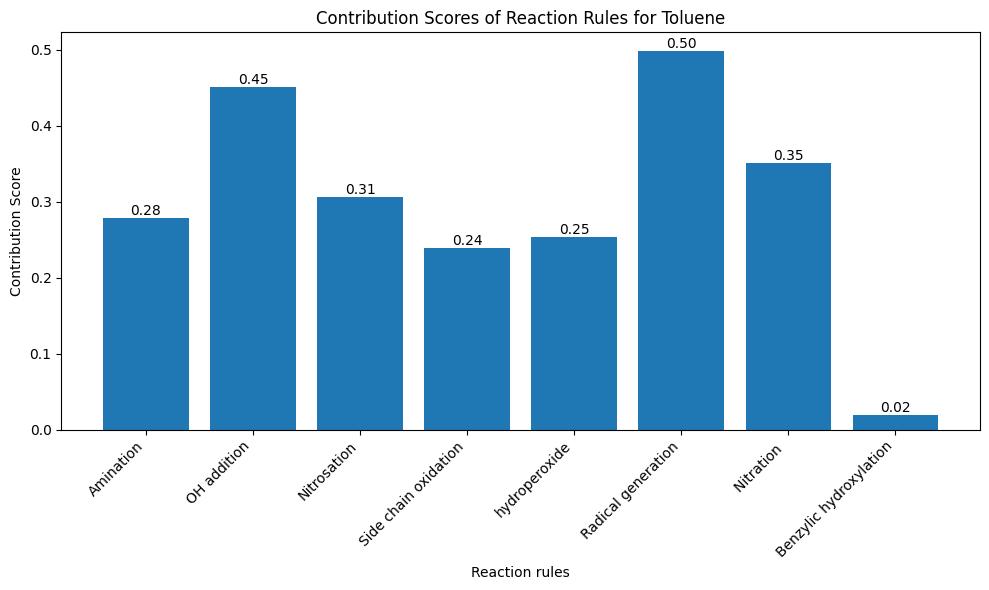

In [9]:
# Plot of contribution score
import matplotlib.pyplot as plt

rule_names = [
    "Radical generation",
    "OH addition",
    "Nitration ",
    "Nitrosation",
    "Amination",
    "hydroperoxide",
    "Side chain oxidation",
    "Benzylic hydroxylation",
]
rule_indices = [rxn_index for rxn_index, stats in ranked_rules]
scores = [stats['matches'] / stats['total'] for rxn_index, stats in ranked_rules]

plt.figure(figsize=(10, 6))
bars= plt.bar(rule_indices, scores)
plt.xlabel("Reaction rules")
plt.ylabel("Contribution Score")
plt.title("Contribution Scores of Reaction Rules for Toluene")
plt.xticks(rule_indices, rule_names,rotation=45, ha='right')

# Values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

#Next reactions

In [10]:
reaction_rules_2 = [

    AllChem.ReactionFromSmarts('[C:1]>>[C:1][N+](=O)[O-]'),           # 0.Nitration_1 (NO₂ addition):            n=2>>13.38% +
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),        # 1.Nitration_2                            n=2>>24.53% +
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),             # 3.Nitrosation_2                          n=2>>25.21% +
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(=O)O'),                 # 4.Carboxylation (COOH addition):         n=2>>35.33% +
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]OO'),                     # 7.Alkyl to hydroperoxide (ROOH addition):n=2>>37.56% +
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2]'),        # 10.Alkene to alcohol                     n=2>>38.42%(*) +
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),     # 11.Dihydroxylation                       n=2>>39.45% +
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)[C:2]'),         # 12.Carbon chain branching addition       n=2>>43.91%
    AllChem.ReactionFromSmarts('[C:1](O)C>>[C:1]'),                   # 14.Dehydration                           n=2>>44.08% +

    AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][NH2]'),               # 15.Amination_2                           n=2>>44.43% +
    AllChem.ReactionFromSmarts('[*:1][*]>>[*:1]C(=O)O'),             # 19.                                       n=2>>44.94% +
    AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][OH]'),             # 22.                                       n=2>>45.11% +
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                 # 26.Generic hydroperoxide formation (ROOH) n=2>>46.14% +
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)'),                 # 43.Oligomer-like C Extension (2-carbon branch)         n=2>>49.06% +
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)(C)'),              # 44.Oligomer-like C Extension (3-carbon branch)         n=2>>52.49% +
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)(C)(C)'),              # Oxime-like formation                                n=2>>53.00%
    AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1](C=CC(=C)C)'),      # 13.polimerization                                     n=2>>59.01%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)C(C)C'),              # Oxime-like formation                                 n=2>>%

    # ************List of TESTED rules*********** #

    #AllChem.ReactionFromSmarts('[C:1]>>[C:1][N]=O'),                 # 2.Nitrosation_1 (NO addition):           n=2>>24.53% -
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(=O)'),                 # 5.Carbonylation (CO addition):           n=2>>35.33% -
    #AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][C:2]'),            # 6.Generic carbon coupling:               n=2>>35.33% -
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1][NH2]'),                 # 8.Amination_1:                           n=2>>37.56% -
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1][*]'),                   # 9.Radical generation                     n=2>>37.56% -

    #AllChem.ReactionFromSmarts('[C:1][N+](=O)[O-]>>[C:1](=O)N(=O)'), # 16.Nitro to nitroso conversion           n=2>>44.43%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][N](=O)'),            # 17.                                      n=2>>44.43%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][N+](=O)[O-]'),       # 18.                                      n=2>>44.43%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][C:2]'),              # 20.                                      n=2>>44.94%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][OH]'),               # 21.                                      n=2>>45.11%
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1]=O'),                # 23.Oxidation of Alcohol to carbonyl      n=2>>45.11%
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),  # 24.Ozonolysis                             n=2>>45.11%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)O'),             # 25.Generic carboxylation                  n=2>>45.11%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),               # 27.Generic hydroxylation                  n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1](C=CC(=C)C)'),        # 28.polymerization                         n=2>>
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),              # 29.Generic amination                      n=2>>46.14%

    #AllChem.ReactionFromSmarts('[C:1](C[OH])>>[C:1](C=O)'),         # 30.Alcohol Oxidation                                     n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1](C=O)>>[C:1](C(=O)O)'),        # 31.Aldehyde to carboxylic acid                           n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][C:2]'),             # 32.Radial coupling                                       n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1](=O)OO>>[C:1](=O)O'),          # 33.Peroxy acid to carboxylic acid                        n=2>>%
    #AllChem.ReactionFromSmarts('[C:1](O)>>[C:1][NH2]'),             # 34.Alcohol to amine                                      n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N]=O'),             # 35.Peroxynitrite formation                               n=2>>46.14%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N+](=O)[O-]'),      # 36.Peroxynitrite formation                               n=2>>%
    #AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),            # 37.Hydroperoxide to alcohol(OOH to OH)                   n=2>>46.14%

    #AllChem.ReactionFromSmarts('[C:1](OO)>>[C:1]=O'),               # 38.ROOH to carbonyl (oxidation)                          n=2>>%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O'),                  # 39.ROO• to to carbonyl (oxidation of hydroperoxide)      n=2>>%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[O]'),               # 40.ROO• to peracid                                       n=2>>%
    #AllChem.ReactionFromSmarts('[C:1](=O)O>>[C:1](=O)[NH2]'),       # 41.Carboxylic acid to amide                              n=2>>%
    #AllChem.ReactionFromSmarts('[C:1]C(=O)[O-]>>[C:1]C(=O)[NH2]'),  # 42.Ammonolysis                                           n=2>>%
    #AllChem.ReactionFromSmarts('[C:1]=O>>[C:1]=N[O]'),              # 45.Oxime-like formation                                 n=2>>52.49%
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)(C)(C)(C)'),              # Oxime-like formation                              n=2>>53.00%
    #AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1]C(C)(C)(C)(C)'),              # Oxime-like formation                         n=2>>53.00%

]

In [11]:
# Next reactions of aliphatic compounds
chemical_space_2 = set(valid_smiles_1)
num_iterations_2 = 2
reaction_history_2 = []

for iteration in range(num_iterations_2):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_2):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # radical correction
                            if "[C*]" in prod_smiles:
                                prod_smiles = create_radical(reactant_smiles)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space_2:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False

                                    # Check within the inner loop
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)
                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                all_matching_smiles.add(prod_smiles)
                                                break
                                        if is_match:
                                            break

                                    reaction_history_2.append((reactant_smiles, rxn_index, prod_smiles, prod_smiles in all_matching_smiles))
                        except:
                            pass

    chemical_space_2.update(temp_new_products)

# Apply threshold
chemical_space_2 = {smi for smi in chemical_space_2
                           if Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols_2 and valid_smiles_2 from chemical_space_2
mols_2 = [Chem.MolFromSmiles(smi) for smi in chemical_space_2]
valid_smiles_2 = list(chemical_space_2)

Streaming output truncated to the last 5000 lines.
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07:50:53] non-ring atom 1 marked aromatic
[07

**Comparison of matching rate**

In [12]:
# Mass calculation and comparison for mols_2

calculated_mw_2 = []
for mol in mols_2:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_2.append(mw)

for i, calculated_mw_value in enumerate(calculated_mw_2):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_2[i] not in all_matching_smiles:
                all_matching_smiles.add(valid_smiles_2[i])

                # Check if the product is match
                is_match = True
            else:
                is_match = False

            reaction_history_2.append((reactant_smiles, rxn_index,prod_smiles, is_match))

            break

# Find matching indices based on all_matching_smiles
matching_excel_info_all = []
for smi in all_matching_smiles:
  calculated_mw_value = Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
  for excel_mw_list, excel_column in zip(
      [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
  ):
    for j, excel_mw_value in enumerate(excel_mw_list):
      diff = abs(calculated_mw_value - excel_mw_value)

      if diff <= tolerance:
        row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
        matching_excel_info_all.append((row_index, excel_column))
        break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 78.73%


In [13]:
# Contribution scores of used rules
rule_contributions = {}
for reactant_smiles, rxn_index, product_smiles, is_match in reaction_history_2:
    rule_contributions.setdefault(rxn_index, {'total': 0, 'matches': 0, 'matching_products': set()})
    rule_contributions[rxn_index]['total'] += 1
    if is_match:
        rule_contributions[rxn_index]['matches'] += 1
        rule_contributions[rxn_index]['matching_products'].add(product_smiles)

ranked_rules = sorted(rule_contributions.items(), key=lambda item: item[1]['matches'] / item[1]['total'] if item[1]['total'] else 0, reverse=True)

for rxn_index, stats in ranked_rules:
    print(f"Rule {rxn_index}: Contribution Score = {stats['matches'] / stats['total'] if stats['total'] else 0:.2f}")

Rule 4: Contribution Score = 0.46
Rule 6: Contribution Score = 0.40
Rule 5: Contribution Score = 0.33
Rule 3: Contribution Score = 0.32
Rule 0: Contribution Score = 0.31
Rule 13: Contribution Score = 0.27
Rule 12: Contribution Score = 0.22
Rule 7: Contribution Score = 0.21
Rule 14: Contribution Score = 0.17
Rule 10: Contribution Score = 0.15
Rule 11: Contribution Score = 0.13
Rule 1: Contribution Score = 0.13
Rule 2: Contribution Score = 0.11
Rule 15: Contribution Score = 0.06
Rule 16: Contribution Score = 0.06
Rule 9: Contribution Score = 0.04
Rule 8: Contribution Score = 0.02
Rule 17: Contribution Score = 0.00


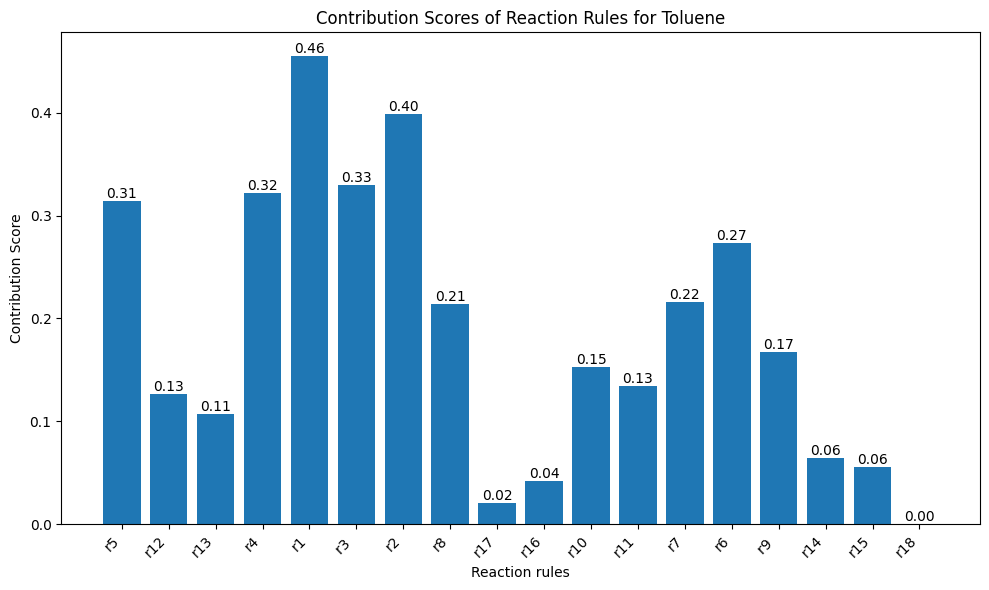

In [14]:
# Plot of contribution score
import matplotlib.pyplot as plt

rule_names = [
    "r1",
    "r2",
    "r3 ",
    "r4",
    "r5",
    "r6",
    "r7",
    "r8",
    "r9 ",
    "r10",
    "r11",
    "r12",
    "r13",
    "r14",
    "r15",
    "r16",
    "r17",
    "r18",

]
rule_indices = [rxn_index for rxn_index, stats in ranked_rules]
scores = [stats['matches'] / stats['total'] for rxn_index, stats in ranked_rules]

plt.figure(figsize=(10, 6))
bars= plt.bar(rule_indices, scores)
plt.xlabel("Reaction rules")
plt.ylabel("Contribution Score")
plt.title("Contribution Scores of Reaction Rules for Toluene")
plt.xticks(rule_indices, rule_names,rotation=45, ha='right')

# Values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

#5. Pathways

Reaction pathway for O=CC(C=C(COO)C(=O)O)=C(O)CN=O:


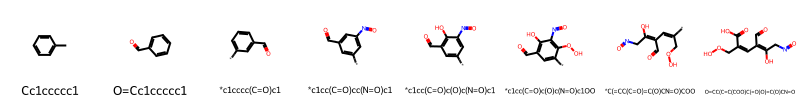

--------------------
Reaction pathway for *c1cc(O)cc(COO)c1N=O:


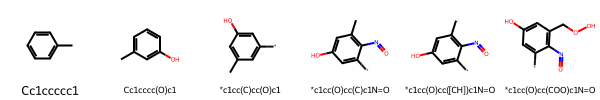

--------------------
Reaction pathway for CC(=C(N)C(N=O)=C(C=O)C(C)COO)[N+](=O)[O-]:


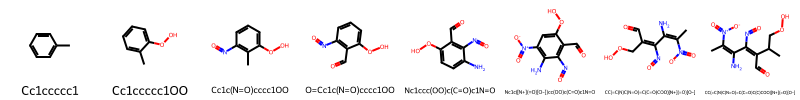

--------------------
Reaction pathway for Cc1cc(N)c(O)c(O)c1[N+](=O)[O-]:


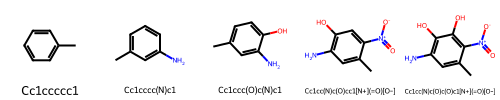

--------------------
Reaction pathway for *C(C(C)=COO)=C(O)C(O)C[N+](=O)[O-]:


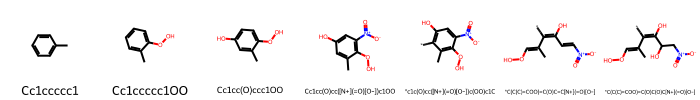

--------------------
Reaction pathway for *C(=C(C[CH])[N+](=O)[O-])C(=C(COO)[N+](=O)[O-])[N+](=O)[O-]:


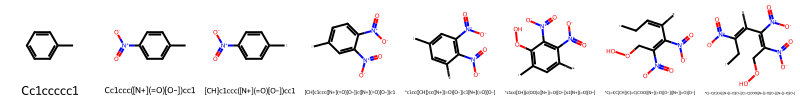

--------------------
Reaction pathway for *CC(N)=C(C=O)C(N=O)=C(COO)C(=O)O:


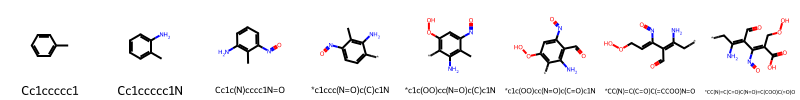

--------------------
Reaction pathway for *C(=C)C(*)C(O)(C(C)=COO)[N+](=O)[O-]:


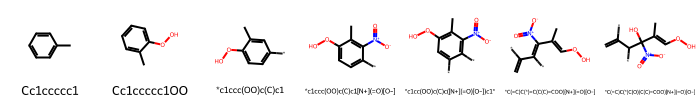

--------------------
Reaction pathway for [CH]CC(O)=C(C(O)=CC(=O)O)[N+](=O)[O-]:


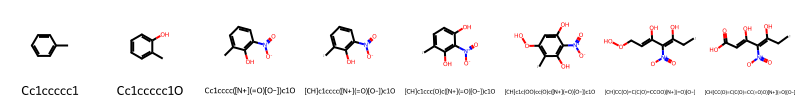

--------------------
Reaction pathway for [CH]C(O)(CC)C(O)=C(COO)N=O:


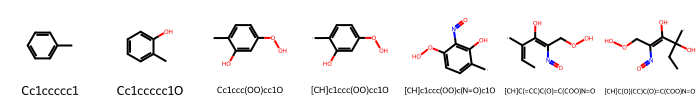

--------------------
Reaction pathway for *c1cc(OO)c(C(=O)C(C)C)c([N+](=O)[O-])c1OO:


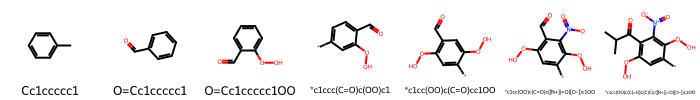

--------------------
Reaction pathway for *c1cc([CH])c(OO)c(N)c1O:


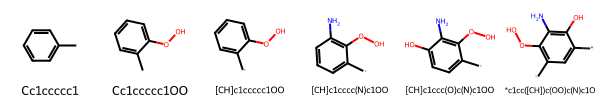

--------------------
Reaction pathway for *C=C(*)C(C)C(N=O)=C(O)C(C)=COO:


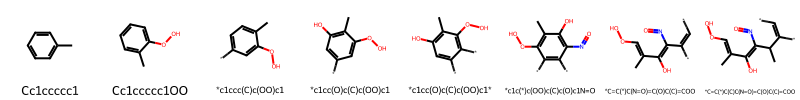

--------------------
Reaction pathway for CCC(=O)c1c(N)cc(O)c(OO)c1OO:


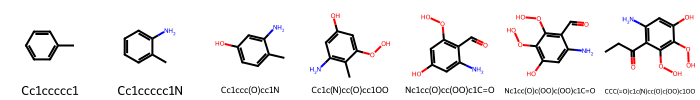

--------------------
Reaction pathway for CC=C(O)C=C(C(O)=COO)[N+](=O)[O-]:


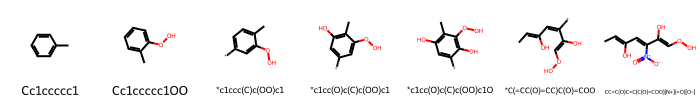

--------------------
Reaction pathway for *C(=CC=CN=O)C([CH])(O)C(O)OO:


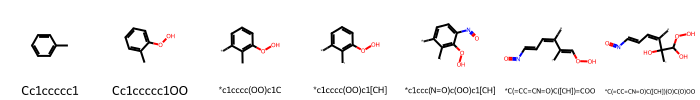

--------------------
Reaction pathway for *c1c(N)c(N=O)c(COO)c([N+](=O)[O-])c1O:


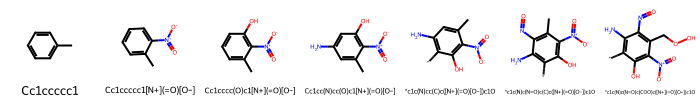

--------------------
Reaction pathway for Nc1cc(C=O)cc(OO)c1N=O:


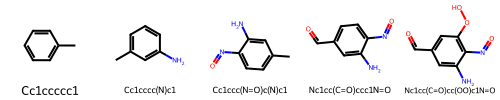

--------------------
Reaction pathway for *C(=CO)C(N)=COO:


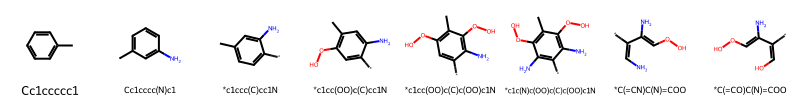

--------------------
Reaction pathway for *c1c(N)c(O)cc([CH])c1OO:


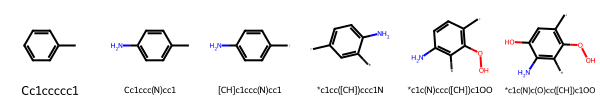

--------------------
Reaction pathway for *C(=C)C(O)(C=O)C(N)C(=COO)[N+](=O)[O-]:


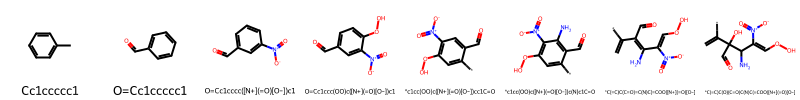

--------------------
Reaction pathway for C=CC=C(C=COO)C[N+](=O)[O-]:


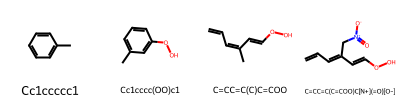

--------------------
Reaction pathway for *C(=CC(=C[CH])C(=O)O)C(=COO)[N+](=O)[O-]:


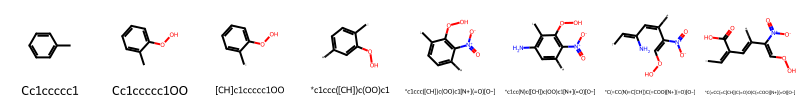

--------------------
Reaction pathway for O=CC(COO)=C(C(O)C[N+](=O)[O-])[N+](=O)[O-]:


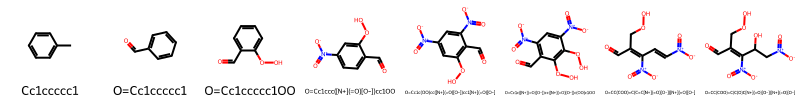

--------------------
Reaction pathway for *C(O)(COO)C(O)C(N=O)=C([CH])CO:


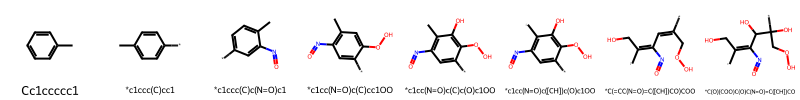

--------------------
Reaction pathway for [CH]C(=CCN)C(=C(O)C(OO)OO)[N+](=O)[O-]:


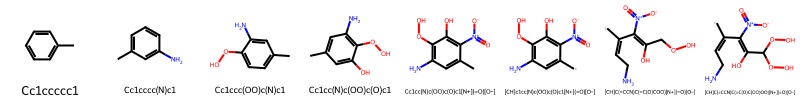

--------------------
Reaction pathway for *c1c(CC(=O)O)c(OO)c(N)c(O)c1OO:


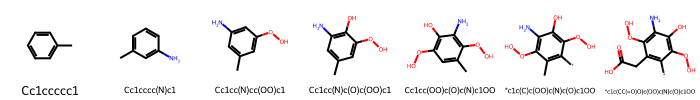

--------------------
Reaction pathway for CC(O)=C(OO)C(O)=C(COO)[N+](=O)[O-]:


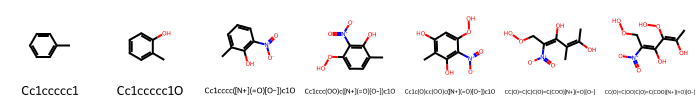

--------------------
Reaction pathway for Nc1cc(OO)c(OC(=O)O)c(C=O)c1N:


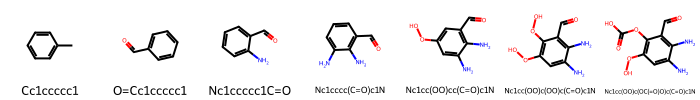

--------------------
Reaction pathway for *C(CC(=O)O)=C([CH])C(=CC[N+](=O)[O-])[N+](=O)[O-]:


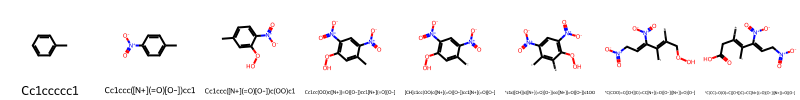

--------------------
Reaction pathway for *c1c(O)c(N=O)c(O)c(C)c1N=O:


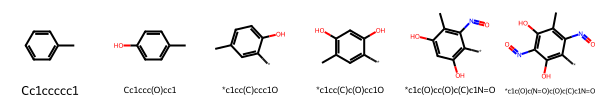

--------------------
Reaction pathway for [CH]C(=CCN=O)C=C(OO)[N+](=O)[O-]:


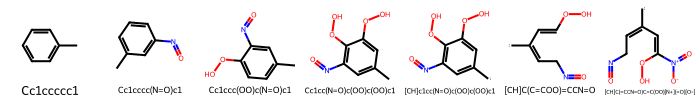

--------------------
Reaction pathway for *c1cc(O)c(CC(=O)O)c(N)c1[N+](=O)[O-]:


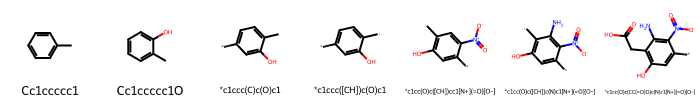

--------------------
Reaction pathway for [CH]c1c(O)cc(OO)c(N=O)c1ON:


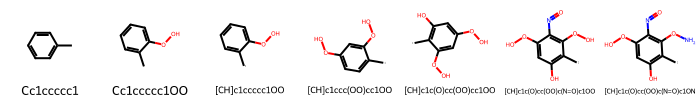

--------------------
Reaction pathway for *C(C(=C)N)=C(C=O)C(=COO)[N+](=O)[O-]:


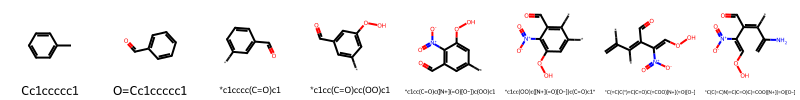

--------------------
Reaction pathway for *c1c(OO)cc(N=O)c(C(=O)C(C)C(C)C)c1N=O:


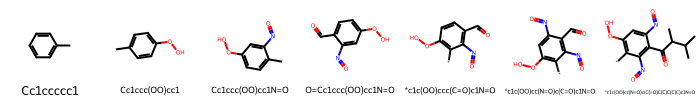

--------------------
Reaction pathway for C=C(C)C(O)=C(OO)[N+](=O)[O-]:


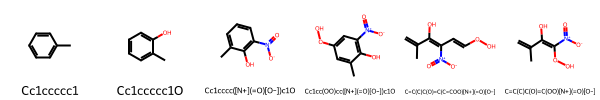

--------------------
Reaction pathway for *C(N=O)=C(O)C(=C(C)CN=O)[N+](=O)[O-]:


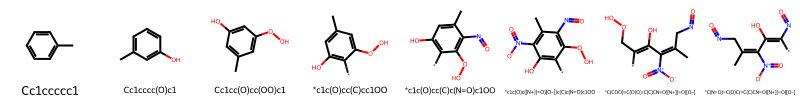

--------------------
Reaction pathway for *C(COO)=C(*)C(=C([CH])C)[N+](=O)[O-]:


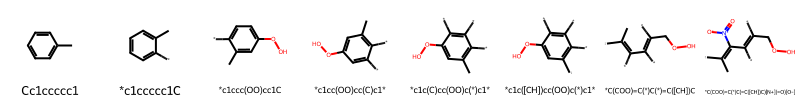

--------------------
Reaction pathway for *CC(C=O)=C(C(C(O)COO)[N+](=O)[O-])[N+](=O)[O-]:


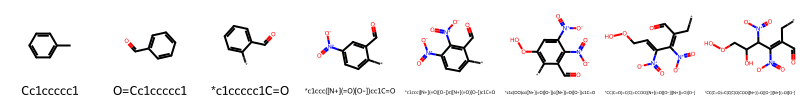

--------------------
Reaction pathway for *C(=CCCC)C(=C(C(*)=COO)[N+](=O)[O-])[N+](=O)[O-]:


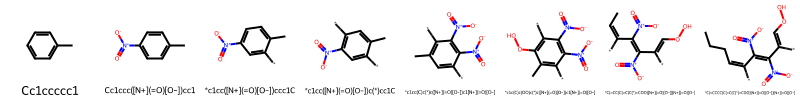

--------------------
Reaction pathway for Nc1cc(OC(=O)O)cc(C=O)c1OO:


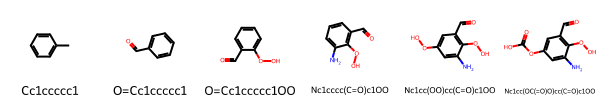

--------------------
Reaction pathway for CC(CN=O)C(=C(C=C(C=O)COO)N=O)[N+](=O)[O-]:


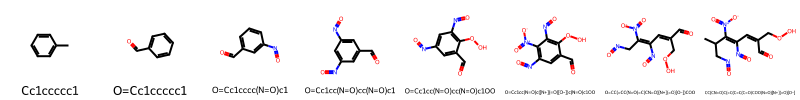

--------------------
Reaction pathway for *c1c(OO)c(N)cc(C(=O)OO)c1[N+](=O)[O-]:


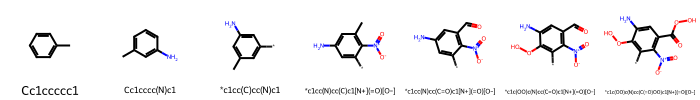

--------------------
Reaction pathway for *C(=C)C(N=O)=C(*)C(=COO)C(=O)OO:


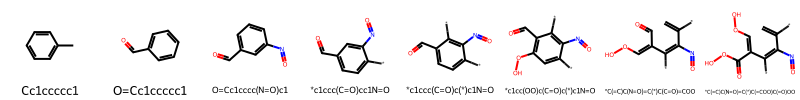

--------------------
Reaction pathway for *C(C(=C(O)C(C=O)=CCOO)[N+](=O)[O-])C(C)C:


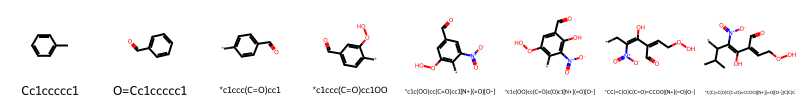

--------------------
Reaction pathway for *c1c(N=O)c(N)c(O)c(O)c1C(=O)O:


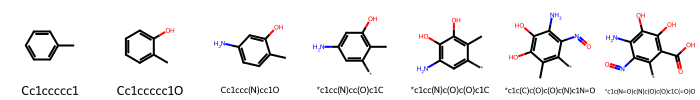

--------------------
Reaction pathway for *C(=CO)C(=C(*)C(N)=COO)[N+](=O)[O-]:


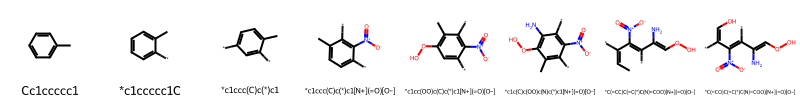

--------------------
Reaction pathway for *C(O)(COO)CC(=C(CC=O)N=O)[N+](=O)[O-]:


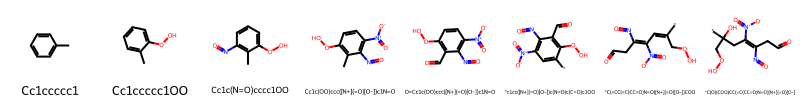

--------------------
Reaction pathway for *c1c(N=O)c(CC(C)(C)C)c([N+](=O)[O-])c(OO)c1OO:


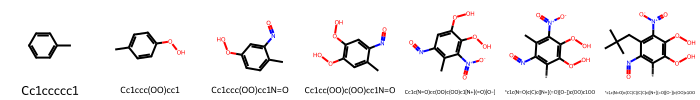

--------------------


In [15]:
# Visualization of pathways
num_smiles_to_trace = 50

# Visualizing the pathways
for i, product_smiles in enumerate(all_matching_smiles):
    if i >= num_smiles_to_trace:
        break

    pathway = trace_reaction_path(product_smiles, reaction_history_1, reaction_history_2)

    if pathway:
        print(f"Reaction pathway for {product_smiles}:")

        # Collect molecules
        pathway_molecules = [Chem.MolFromSmiles(pathway[0][0])]
        legends = [pathway[0][0]]

        for step in pathway:
            reactant, rxn_index, product = step[0:3]
            product_mol = Chem.MolFromSmiles(product)

            if product_mol is not None and product_mol not in pathway_molecules:
                pathway_molecules.append(product_mol)
                legends.append(product)

        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                   subImgSize=(100, 100), legends=legends, useSVG=True)
        display(img)
        print("-" * 20)